# "American sign language classifier from scratch"

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [classifier, scratch, vision]
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
from fastai.vision.all import *
import pandas as pd
from fastbook import plot_function

In [2]:
df = pd.read_csv('/code/datasets/mnist_sign/sign_mnist_train.csv')
classes = [3, 1, 23, 22]
df = df[df.label.isin(classes)]
train_df = df.sample(frac=0.8, random_state=100)
test_df = df.drop(train_df.index)

train_df.shape, test_df.shape

((3676, 785), (919, 785))

In [3]:
def get_labels(df):
    return tensor(df.iloc[:, 0].values).unsqueeze(1)

def get_image_tensors(df):
    return torch.stack([tensor(image_array)/255. for image_array in df.iloc[:, 1:].values])

def get_dataset(df):
    return zip(get_labels(df), get_image_tensors(df))

In [4]:
dataset = get_dataset(df)

tensor([3])
tensor([22])


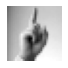

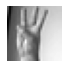

In [5]:
for label, image_tensor in list(dataset)[:2]:
    print(label)
    show_image(torch.reshape(image_tensor, (28, 28)), cmap='gray')

In [6]:
??show_image

### Initialize weights

In [7]:
def get_random_weights(rows, cols):
    return torch.randn(rows, cols).requires_grad_()

In [8]:
weights = get_random_weights(28*28, len(classes))
bias = get_random_weights(1, len(classes))
weights.shape, bias.shape

(torch.Size([784, 4]), torch.Size([1, 4]))

### Get Predictions 

In [9]:
image_tensors = get_image_tensors(train_df)
image_tensors.shape, weights.shape

(torch.Size([3676, 784]), torch.Size([784, 4]))

In [10]:
def get_predictions(image_tensors, weights, bias):
    return image_tensors@weights + bias

In [11]:
predictions = get_predictions(image_tensors, weights, bias)
predictions.shape

torch.Size([3676, 4])

Check initial accuracy

In [12]:
test_image_tensors, test_labels = get_image_tensors(test_df), get_labels(test_df)
test_preds = get_predictions(test_image_tensors, weights, bias)
pred_classes = torch.argmax(test_preds, dim=1)

# This will select the class value based on index of pred_classes
preds = tensor(classes).gather(0, pred_classes)
(preds == test_labels).float().mean() 

# Random weights are ~26% accurate

tensor(0.2557)

### Calculate loss

In [30]:
labels = get_labels(train_df)
# get each label class
target_classes = tensor([classes.index(c) for c in labels.view(-1)])
target_classes[:5]

tensor([2, 0, 3, 0, 3])

In [67]:
# softmax function turns the predictions into probabilities and amplifies the predictions 
def softmax(predictions):
    return torch.exp(predictions)/torch.exp(predictions).sum(dim=1, keepdim=True)
# pytorch equivalent
activations_py = torch.softmax(predictions, dim=1)
activations = softmax(predictions)

activations[0], activations_py[0]

(tensor([1.5480e-16, 1.2497e-05, 8.2206e-08, 9.9999e-01], grad_fn=<SelectBackward>),
 tensor([1.5480e-16, 1.2497e-05, 8.2206e-08, 9.9999e-01], grad_fn=<SelectBackward>))

In [66]:
# mean of corresponding activations based on the target class
loss = activations[range(len(target_classes)), target_classes].mean()
# pytorch equivalent 
loss_py = -F.nll_loss(activations, target_classes)

loss, loss_py

(tensor(0.2702, grad_fn=<MeanBackward0>),
 tensor(0.2702, grad_fn=<NegBackward>))

In [52]:
# as softmax function turns predictions into probabilities, each activation is bounded between (0, 1) hence our model considers 0.900 and 0.999 as the same but the second prediction is 100 times more confident hence we use log to amplify the domain to (-inf, inf)

In [58]:
activations[0], torch.log(activations[0])

(tensor([1.5480e-16, 1.2497e-05, 8.2206e-08, 9.9999e-01], grad_fn=<SelectBackward>),
 tensor([-3.6404e+01, -1.1290e+01, -1.6314e+01, -1.2517e-05], grad_fn=<LogBackward>))

In [78]:
# softmax + log + negative_loss_likelyhood = cross_entropy_loss: this can be used for classification problems
def cross_entropy_loss(predictions, target_classes): 
    activations = softmax(predictions)
    activations_log = torch.log(activations)
    loss = activations_log[range(len(target_classes)), target_classes].mean()
    return -loss
# pytorch equivalent
cross_entropy_loss_py = F.cross_entropy(predictions, target_classes)

cross_entropy_loss(predictions, target_classes), cross_entropy_loss_py

(tensor(18.2121, grad_fn=<NegBackward>),
 tensor(18.2121, grad_fn=<NllLossBackward>))

### Optimise weights